# 1. Setup and Configuration

## 1.1 Import Libraries

In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard ,Callback,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score,roc_curve, auc
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from skimage import exposure, filters
# import albumentations as A
import warnings
import time
import math
warnings.filterwarnings('ignore')

## 1.2 Define Constants

### Defines dataset paths, subfolders, and blur detection thresholds to avoid repetition across cells.

In [2]:
ROOT_PATH = "E:\\team\\Project_Dataset\\blood_cells_data"
OUTPUT_BASE_PATH = os.path.join(ROOT_PATH, "preprocessed_cells")
SUBFOLDERS = [
    "Normal_Neutrophils", "Normal_Lymphocytes", "Normal_Eosinophils",
    "Normal_Monocytes", "Normal_Basophils", "Leukemia_Blast", "rbc"
]
BLUR_THRESHOLDS = {
    "rbc": 50,
    "Normal_Neutrophils": 150,
    "Normal_Lymphocytes": 200,
    "Normal_Eosinophils": 150,
    "Normal_Monocytes": 150,
    "Normal_Basophils": 150,
    "Leukemia_Blast": 600
}


# 2. Data Exploration

## 2.1 Count Images per Category

### Counts the number of images in each subfolder to verify dataset availability and structure.

In [3]:
def count_images_per_folder():
    print("Image Count per Folder:\n")
    for folder in SUBFOLDERS:
        folder_path = os.path.join(ROOT_PATH, folder)
        if os.path.exists(folder_path):
            image_files = []
            IMAGE_EXTENSIONS = ('*.jpg', '*.jpeg', '*.png')
            for ext in IMAGE_EXTENSIONS:
                image_files.extend(glob.glob(os.path.join(folder_path, ext)))
            print(f"{folder:<22}: {len(image_files):>5} images")
        else:
            print(f"{folder:<22}: Folder not found!")
count_images_per_folder()

Image Count per Folder:

Normal_Neutrophils    :  5591 images
Normal_Lymphocytes    :  3494 images
Normal_Eosinophils    :  1645 images
Normal_Monocytes      :  1554 images
Normal_Basophils      :   789 images
Leukemia_Blast        :  4281 images
rbc                   :  1876 images


## 2.2 Load Annotation Files

### Loads and summarizes annotation CSV files if available.

In [4]:
def load_annotations():
    annotations_path = os.path.join(ROOT_PATH, "wbc_annotations")
    if os.path.exists(annotations_path):
        try:
            general_wbc_df = pd.read_csv(os.path.join(annotations_path, "general_wbc_annotations.csv"))
            whole_slides_df = pd.read_csv(os.path.join(annotations_path, "whole_slides_annotations.csv"))
            print("\nAnnotation files loaded successfully.\n")
            print(f"general_wbc_annotations.csv     → {len(general_wbc_df)} records")
            print(f"whole_slides_annotations.csv    → {len(whole_slides_df)} records")
        except Exception as e:
            print("\nFailed to load annotation files.")
            print(f"Error: {e}")
    else:
        print("\nAnnotation folder not found. Skipping annotation loading.")
load_annotations()


Annotation files loaded successfully.

general_wbc_annotations.csv     → 2340 records
whole_slides_annotations.csv    → 1818 records


# 3. Image Quality Analysis

## 3.1 Analyze Laplacian Variance

### Computes Laplacian variance for a sample of images in each folder, evaluates blurriness against thresholds, and generates histograms.


Analyzing Laplacian Variance for sample images:

Normal_Neutrophils:
  Percentage with threshold 150: 100.00% of 10 images
  Mean Variance: 872.27
  Min Variance: 688.27
  Max Variance: 1025.52
  Std Variance: 103.17
  Testing different thresholds:
    Threshold 50: 100.00%
    Threshold 100: 100.00%
    Threshold 150: 100.00%
    Threshold 200: 100.00%
    Threshold 250: 100.00%


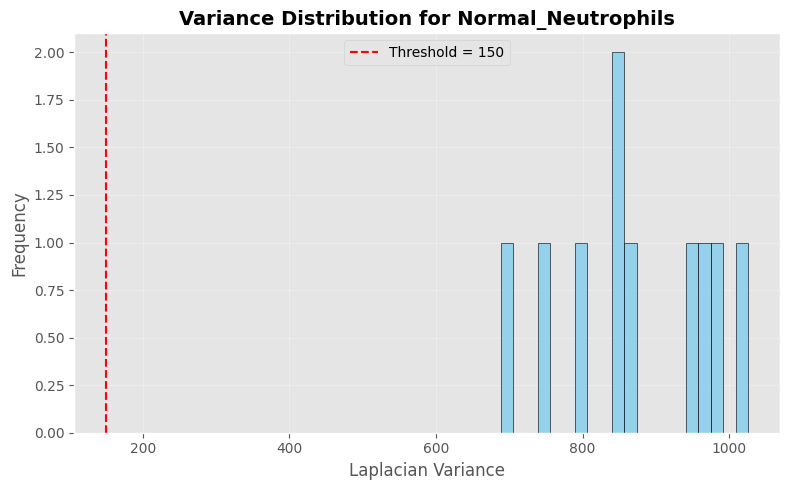


Normal_Lymphocytes:
  Percentage with threshold 200: 100.00% of 10 images
  Mean Variance: 727.44
  Min Variance: 490.80
  Max Variance: 1093.90
  Std Variance: 167.74
  Testing different thresholds:
    Threshold 50: 100.00%
    Threshold 100: 100.00%
    Threshold 150: 100.00%
    Threshold 200: 100.00%
    Threshold 250: 100.00%


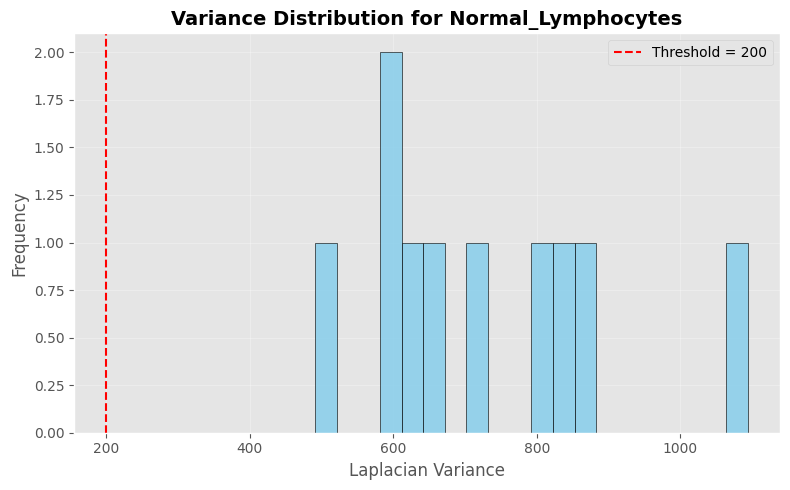


Normal_Eosinophils:
  Percentage with threshold 150: 100.00% of 10 images
  Mean Variance: 796.71
  Min Variance: 518.52
  Max Variance: 1099.11
  Std Variance: 186.42
  Testing different thresholds:
    Threshold 50: 100.00%
    Threshold 100: 100.00%
    Threshold 150: 100.00%
    Threshold 200: 100.00%
    Threshold 250: 100.00%


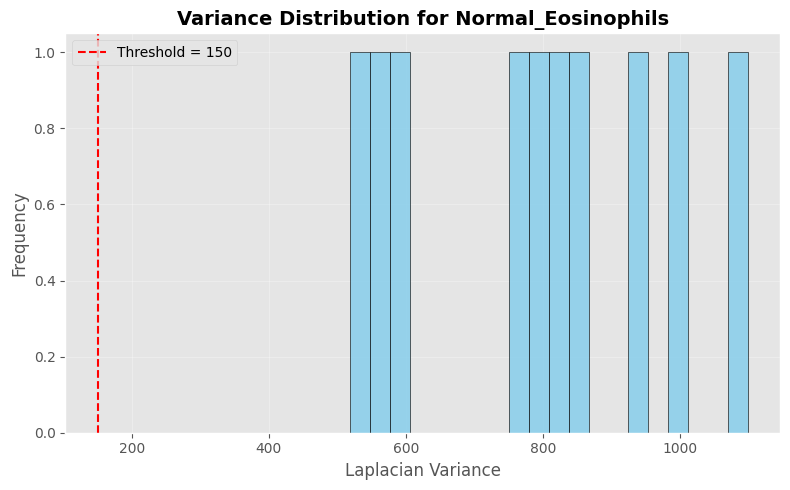


Normal_Monocytes:
  Percentage with threshold 150: 100.00% of 10 images
  Mean Variance: 705.55
  Min Variance: 504.62
  Max Variance: 964.49
  Std Variance: 141.44
  Testing different thresholds:
    Threshold 50: 100.00%
    Threshold 100: 100.00%
    Threshold 150: 100.00%
    Threshold 200: 100.00%
    Threshold 250: 100.00%


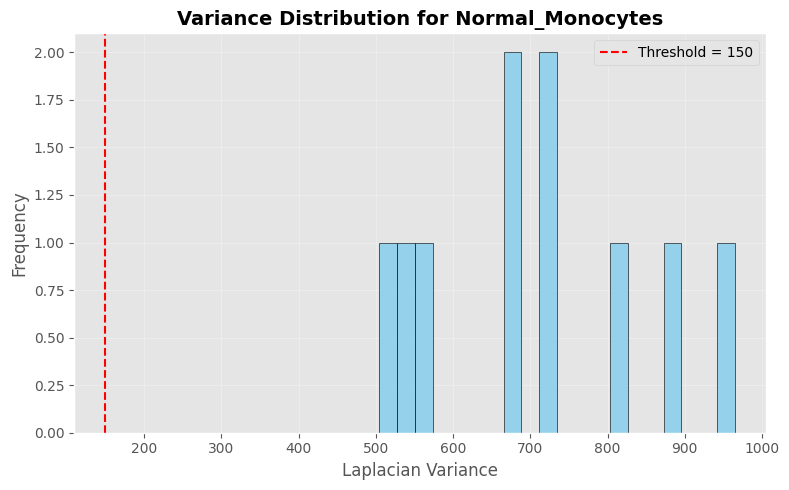


Normal_Basophils:
  Percentage with threshold 150: 10.00% of 10 images
  Mean Variance: 91.13
  Min Variance: 22.64
  Max Variance: 166.81
  Std Variance: 51.65
  Testing different thresholds:
    Threshold 50: 60.00%
    Threshold 100: 60.00%
    Threshold 150: 10.00%
    Threshold 200: 0.00%
    Threshold 250: 0.00%


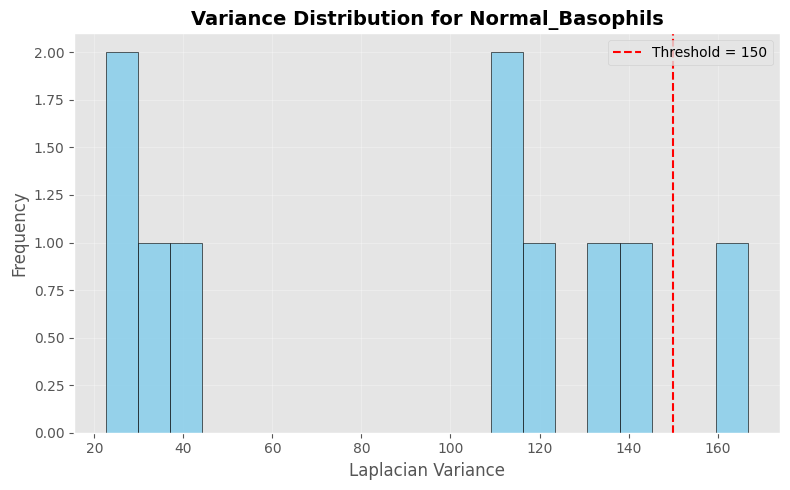


Leukemia_Blast:
  Percentage with threshold 600: 0.00% of 10 images
  Mean Variance: 62.00
  Min Variance: 50.70
  Max Variance: 74.29
  Std Variance: 8.25
  Testing different thresholds:
    Threshold 50: 100.00%
    Threshold 100: 0.00%
    Threshold 150: 0.00%
    Threshold 200: 0.00%
    Threshold 250: 0.00%


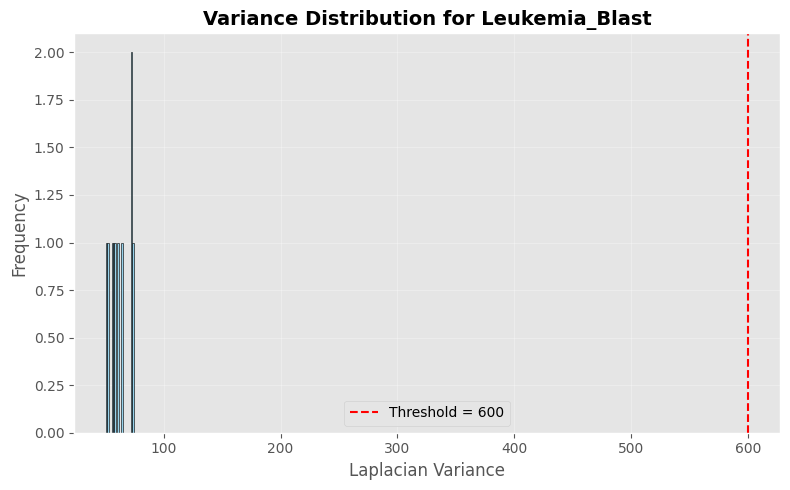


rbc:
  Percentage with threshold 50: 0.00% of 10 images
  Mean Variance: 2.28
  Min Variance: 1.75
  Max Variance: 2.55
  Std Variance: 0.28
  Testing different thresholds:
    Threshold 50: 0.00%
    Threshold 100: 0.00%
    Threshold 150: 0.00%
    Threshold 200: 0.00%
    Threshold 250: 0.00%


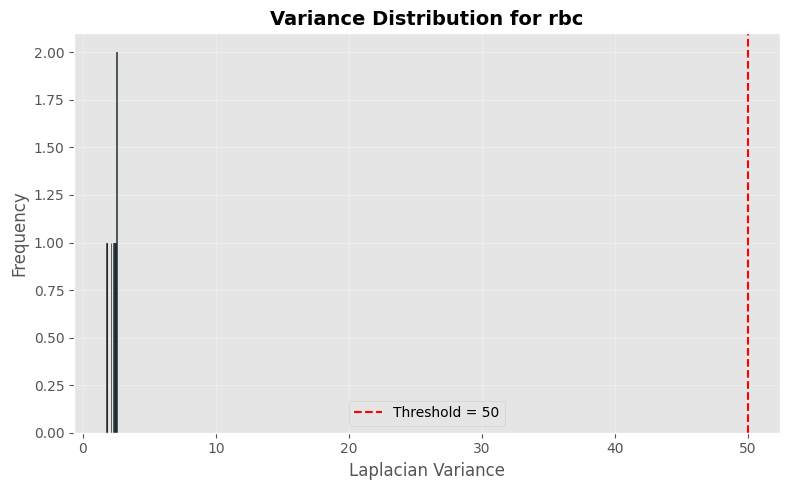

In [5]:
def analyze_laplacian_variance(folder_path, folder_name, num_samples=10):
    image_files = []
    IMAGE_EXTENSIONS = ('*.jpg', '*.jpeg', '*.png')
    for ext in IMAGE_EXTENSIONS:
        image_files.extend(glob.glob(os.path.join(folder_path, ext)))
    
    threshold = BLUR_THRESHOLDS.get(folder_name, 100)
    valid_images = 0
    total_images = 0
    variances = []
    
    for img_path in image_files[:num_samples]:
        img = cv2.imread(img_path)
        if img is not None:
            total_images += 1
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            variances.append(laplacian_var)
            if laplacian_var >= threshold:
                valid_images += 1
    
    percentage = (valid_images / total_images) * 100 if total_images > 0 else 0
    return percentage, total_images, variances

def plot_variance_histogram(folder, variances, threshold):
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 5))
    plt.hist(variances, bins=20, color='skyblue', edgecolor='black', alpha=0.85)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.title(f'Variance Distribution for {folder}', fontsize=14, fontweight='bold')
    plt.xlabel('Laplacian Variance', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(ROOT_PATH, f"{folder}_variance_histogram.png"), dpi=300)
    plt.show()

def analyze_all_folders():
    print("\nAnalyzing Laplacian Variance for sample images:")
    for folder in SUBFOLDERS:
        folder_path = os.path.join(ROOT_PATH, folder)
        if os.path.exists(folder_path):
            percentage, total_images, variances = analyze_laplacian_variance(folder_path, folder)
            threshold = BLUR_THRESHOLDS.get(folder, 100)
            
            if variances:
                print(f"\n{folder}:")
                print(f"  Percentage with threshold {threshold}: {percentage:.2f}% of {total_images} images")
                print(f"  Mean Variance: {np.mean(variances):.2f}")
                print(f"  Min Variance: {np.min(variances):.2f}")
                print(f"  Max Variance: {np.max(variances):.2f}")
                print(f"  Std Variance: {np.std(variances):.2f}")
                
                test_thresholds = [50, 100, 150, 200, 250]
                print("  Testing different thresholds:")
                for test_threshold in test_thresholds:
                    valid_images = sum(1 for var in variances if var >= test_threshold)
                    test_percentage = (valid_images / total_images) * 100 if total_images > 0 else 0
                    print(f"    Threshold {test_threshold}: {test_percentage:.2f}%")
                
                plot_variance_histogram(folder, variances, threshold)
        else:
            print(f"{folder}: Folder not found")
analyze_all_folders()

# 4. Image Preprocessing

## 4.1 Initialize Output Directory and Log File

## Sets up the output directory for preprocessed images and creates a log file to record preprocessing details, ensuring a clean environment for storing results.

In [6]:
output_base_path = os.path.join(ROOT_PATH, "preprocessed_cells")

if not os.path.exists(output_base_path):
    os.makedirs(output_base_path)

log_file = os.path.join(output_base_path, "preprocessing_log.txt")
with open(log_file, "w") as f:
    f.write("Preprocessing Log\n")


## 4.2 Define Blur Detection Function

### Defines the is_blurry function to identify blurry images by calculating the Laplacian variance and comparing it against folder-specific thresholds, logging the results.

In [7]:
def is_blurry(image, folder, default_threshold=100):
    thresholds = {
        "rbc": 2,
        "Normal_Neutrophils": 100,
        "Normal_Lymphocytes": 100,
        "Normal_Eosinophils": 150,
        "Normal_Monocytes": 150,
        "Normal_Basophils": 50,
        "Leukemia_Blast": 100
    }
    threshold = thresholds.get(folder, default_threshold)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    is_blur = laplacian_var < threshold

    with open(log_file, "a") as f:
        f.write(f"Image: {img_path}, Folder: {folder}, Variance: {laplacian_var:.2f}, Threshold: {threshold:.1f}, Blurry: {is_blur}\n")
    
    return is_blur


## 4.3 Define Image Preprocessing Function

### Implements the preprocess_image function to load, check for blur, resize, and convert images to RGB format, returning processed images or None for invalid cases.

In [8]:
def preprocess_image(img_path, folder, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        with open(log_file, "a") as f:
            f.write(f"Failed to load image: {img_path}\n")
        return None
    if is_blurry(img, folder):
        return None
    img_resized = cv2.resize(img, target_size)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    return img_rgb


### 4.4 Process Images Across Folders

Loops through dataset folders, applies preprocessing to each image, and saves valid images to corresponding output directories while tracking counts.

In [9]:
total_original_images = 0
total_processed_images = 0
filtered_counts = {folder: 0 for folder in SUBFOLDERS}

for folder in SUBFOLDERS:
    folder_path = os.path.join(ROOT_PATH, folder)
    if not os.path.exists(folder_path):
        continue

    label = folder.replace("Normal_", "").replace("Leukemia_", "")
    output_folder = os.path.join(output_base_path, label)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, f"*{ext}")))

    total_images = len(image_files)
    total_original_images += total_images
    if total_images == 0:
        continue

    for img_path in image_files:
        processed_img = preprocess_image(img_path, folder)
        if processed_img is not None:
            filename = os.path.basename(img_path).split('.')[0] + ".png"
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
            total_processed_images += 1
            filtered_counts[folder] += 1


## 4.5 Display Preprocessing Summary

### Prints a summary of the preprocessing results, including the total number of original and processed images, and the count of processed images per category.

In [10]:
print(f"Total original images: {total_original_images}")
print(f"Total processed images: {total_processed_images}")

for folder in filtered_counts:
    print(f"{folder}: {filtered_counts[folder]} images")

for label in os.listdir(output_base_path):
    folder_path = os.path.join(output_base_path, label)
    if os.path.isdir(folder_path):
        images = len(os.listdir(folder_path))
        print(f"{label}: {images} images")


Total original images: 19230
Total processed images: 8633
Normal_Neutrophils: 669 images
Normal_Lymphocytes: 1463 images
Normal_Eosinophils: 625 images
Normal_Monocytes: 622 images
Normal_Basophils: 417 images
Leukemia_Blast: 3419 images
rbc: 1418 images
Basophils: 417 images
Blast: 3419 images
Eosinophils: 625 images
Lymphocytes: 1463 images
Monocytes: 622 images
Neutrophils: 669 images
rbc: 1418 images


## 4.6 Log Preprocessing Summary

### Appends a detailed summary of the preprocessing results to the log file, including total and per-category image counts for record-keeping.

In [11]:
with open(log_file, "a") as f:
    f.write("\nSummary:\n")
    f.write(f"Total original images: {total_original_images}\n")
    f.write(f"Total processed images: {total_processed_images}\n")
    f.write("Filtered images per category:\n")
    for folder in SUBFOLDERS:
        f.write(f"{folder}: {filtered_counts[folder]} images\n")


# Data Preparation and Augmentation

In [12]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Paths ===
PREPROCESSED_PATH = os.path.join(ROOT_PATH, "preprocessed_cells_clahe_denoise")
if not os.path.exists(PREPROCESSED_PATH):
    os.makedirs(PREPROCESSED_PATH)

# === Enhance and Save Images ===
def enhance_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None

    # Resize
    img = cv2.resize(img, target_size)

    # Denoise
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    # CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return final

image_paths = []
labels = []

for label in os.listdir(PREPROCESSED_PATH.replace("_clahe_denoise", "")):  # Assuming original = "preprocessed_cells"
    folder_path = os.path.join(PREPROCESSED_PATH.replace("_clahe_denoise", ""), label)
    if os.path.isdir(folder_path):
        output_folder = os.path.join(PREPROCESSED_PATH, label)
        os.makedirs(output_folder, exist_ok=True)

        for img_path in glob.glob(os.path.join(folder_path, "*.png")):
            processed = enhance_image(img_path)
            if processed is not None:
                filename = os.path.basename(img_path)
                save_path = os.path.join(output_folder, filename)
                cv2.imwrite(save_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))  # Save in BGR format
                image_paths.append(save_path)
                labels.append(label)

# === Encode Labels ===
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# === Split ===
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.3, stratify=labels_encoded, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.33, stratify=temp_labels, random_state=42
)

# === DataFrames ===
train_df = pd.DataFrame({"filename": train_paths, "class": train_labels})
val_df = pd.DataFrame({"filename": val_paths, "class": val_labels})
test_df = pd.DataFrame({"filename": test_paths, "class": test_labels})

train_df["class"] = le.inverse_transform(train_df["class"])
val_df["class"] = le.inverse_transform(val_df["class"])
test_df["class"] = le.inverse_transform(test_df["class"])

# === Generators ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.35,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# === Compute Class Weights ===
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))


Found 6043 validated image filenames belonging to 7 classes.
Found 1735 validated image filenames belonging to 7 classes.
Found 855 validated image filenames belonging to 7 classes.


In [13]:
train_df.to_csv(os.path.join(ROOT_PATH, "train_df.csv"), index=False)
val_df.to_csv(os.path.join(ROOT_PATH, "val_df.csv"), index=False)
test_df.to_csv(os.path.join(ROOT_PATH, "test_df.csv"), index=False)

# Also save the label encoder if needed
import pickle
with open(os.path.join(ROOT_PATH, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(ROOT_PATH, "class_weights.pkl"), "wb") as f:
    pickle.dump(class_weights_dict, f)


In [14]:
train_df = pd.read_csv(os.path.join(ROOT_PATH, "train_df.csv"))
val_df = pd.read_csv(os.path.join(ROOT_PATH, "val_df.csv"))
test_df = pd.read_csv(os.path.join(ROOT_PATH, "test_df.csv"))

with open(os.path.join(ROOT_PATH, "label_encoder.pkl"), "rb") as f:
    le = pickle.load(f)
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="categorical"
)
with open(os.path.join(ROOT_PATH, "class_weights.pkl"), "rb") as f:
    class_weights_dict = pickle.load(f)


Found 6043 validated image filenames belonging to 7 classes.


In [15]:
from tensorflow.keras.optimizers import Adam
class LRFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-2, steps=189):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lr_mult = (max_lr / min_lr) ** (1 / steps)
        self.history = {}
        self.iteration = 0
        self.lrs = []
        self.losses = []

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.iteration += 1
        lr = self.min_lr * (self.lr_mult ** self.iteration)
        # tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        self.model.optimizer.learning_rate.assign(lr)

        self.lrs.append(lr)
        self.losses.append(logs["loss"])

        if self.iteration >= self.steps:
            self.model.stop_training = True

def build_improved_model():
    model = Sequential([
        
        Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3), padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
 
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(256, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(7, activation="softmax")
    ])
    return model

model_for_lr = build_improved_model()


model_for_lr.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-2, steps=189)

model_for_lr.fit(
    train_generator,
    steps_per_epoch=189,
    epochs=5,
    callbacks=[lr_finder],
    verbose=1
)

plt.figure(figsize=(8, 5))
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Loss")
plt.title("Learning Rate Finder (Improved CNN)")
plt.grid(True)
plt.tight_layout()
plt.savefig("lr_finder_plot_improved.png")
plt.show()



Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 12544, but received input with shape (None, 4096)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(7, activation="softmax")
])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=1
)

model.save(os.path.join(ROOT_PATH, "final_blood_cell_classifier.h5"))


Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5387 - loss: 1.6463

189/189 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.5389 - loss: 1.6450 - val_accuracy: 0.1643 - val_loss: 4.1965 - learning_rate: 1.0000e-04
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6351 - loss: 1.0858

189/189 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.6351 - loss: 1.0856 - val_accuracy: 0.3983 - val_loss: 1.6391 - learning_rate: 1.0000e-04
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6619 - loss: 1.0040

189/189 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.6620 - loss: 1.0037 - val_accuracy: 0.7706 - val_loss: 0.5938 - learning_rate: 1.0000e-04
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7046 - loss: 0.9521

189/189 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.7046 - loss: 0.9519 - val_accuracy: 0.7545 - val_loss: 0.5916 - learning_rate: 1.0000e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.7351 - loss: 0.8515 - val_accuracy: 0.7504 - val_loss: 0.6303 - learning_rate: 1.0000e-04
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7419 - loss: 0.8248

189/189 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.7418 - loss: 0.8249 - val_accuracy: 0.8121 - val_loss: 0.4911 - learning_rate: 1.0000e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7552 - loss: 0.7966

189/189 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7552 - loss: 0.7965 - val_accuracy: 0.8357 - val_loss: 0.4522 - learning_rate: 1.0000e-04
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7743 - loss: 0.7481 - val_accuracy: 0.7043 - val_loss: 0.8119 - learning_rate: 1.0000e-04
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.7819 - loss: 0.7403 - val_accuracy: 0.7988 - val_loss: 0.5581 - learning_rate: 1.0000e-04
Epoch 10/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7879 - loss: 0.7110
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
189/189 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7879 - loss: 0.7110 - val_accuracy: 0.5072 - val_loss: 2.9521 - learning_rate: 1.0000e-04
Epoch 11/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8075 - loss: 0.6596

189/189 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8076 - loss: 0.6596 - val_accuracy: 0.8703 - val_loss: 0.3720 - learning_rate: 5.0000e-05
Epoch 12/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.8114 - loss: 0.6252 - val_accuracy: 0.6012 - val_loss: 1.0992 - learning_rate: 5.0000e-05
Epoch 13/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8224 - loss: 0.5984

189/189 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.8225 - loss: 0.5984 - val_accuracy: 0.8767 - val_loss: 0.3150 - learning_rate: 5.0000e-05
Epoch 14/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8362 - loss: 0.5569

189/189 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.8362 - loss: 0.5571 - val_accuracy: 0.9141 - val_loss: 0.2613 - learning_rate: 5.0000e-05
Epoch 15/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.8262 - loss: 0.5934 - val_accuracy: 0.9061 - val_loss: 0.2673 - learning_rate: 5.0000e-05
Epoch 16/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.8388 - loss: 0.5395 - val_accuracy: 0.8818 - val_loss: 0.3259 - learning_rate: 5.0000e-05
Epoch 17/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8429 - loss: 0.5368
Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
189/189 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.8430 - loss: 0.5368 - val_accuracy: 0.8536 - val_loss: 0.3502 - learning_rate: 5.0000e-05
Epoch 18/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8597 - loss: 0.5025 - val_accuracy: 0.8761 - val_loss: 0.3041 - learning_rate: 2.5000e-05
Epoch 19/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8526 

189/189 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.8526 - loss: 0.4952 - val_accuracy: 0.9216 - val_loss: 0.2300 - learning_rate: 2.5000e-05
Epoch 20/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8731 - loss: 0.4711 - val_accuracy: 0.8997 - val_loss: 0.2456 - learning_rate: 2.5000e-05
Epoch 21/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8738 - loss: 0.4609

189/189 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.8738 - loss: 0.4609 - val_accuracy: 0.9349 - val_loss: 0.2134 - learning_rate: 2.5000e-05
Epoch 22/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8744 - loss: 0.4342

189/189 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.8744 - loss: 0.4342 - val_accuracy: 0.9464 - val_loss: 0.1959 - learning_rate: 2.5000e-05
Epoch 23/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8693 - loss: 0.4533

189/189 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.8693 - loss: 0.4532 - val_accuracy: 0.9435 - val_loss: 0.1861 - learning_rate: 2.5000e-05
Epoch 24/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.8792 - loss: 0.4085 - val_accuracy: 0.9222 - val_loss: 0.2273 - learning_rate: 2.5000e-05
Epoch 25/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8814 - loss: 0.4325

189/189 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.8815 - loss: 0.4325 - val_accuracy: 0.9504 - val_loss: 0.1757 - learning_rate: 2.5000e-05
Epoch 26/50
175/189 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8698 - loss: 0.4450

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# === Define the model ===
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(224, 224, 3), kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    Dense(128, activation="relu", kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(7, activation="softmax")
])

# === Compile ===
optimizer = Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# === Callbacks ===
early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# === Training ===
history = model.fit(
    train_generator,  # Make sure this is based on 128x128 images now
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    class_weight=class_weights_dict,
    verbose=1
)

# === Save the final model ===
model.save(os.path.join(ROOT_PATH, "final_blood_cell_classifier_128x128.h5"))

Epoch 1/25


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:

import pickle
history_file_path = os.path.join(ROOT_PATH, "history.pkl")

history_dict = {
    "accuracy": [
        0.6091, 0.7447, 0.7897, 0.8145, 0.8297, 0.8409, 0.8498, 0.8587, 0.8655,
        0.8701, 0.8732, 0.8781, 0.8830, 0.8864, 0.8895, 0.8929, 0.8957, 0.8985,
        0.9016, 0.9026, 0.9041, 0.9062, 0.9087, 0.9105, 0.9115, 0.9130, 0.9148,
        0.9163, 0.9181, 0.9196, 0.9206, 0.9224, 0.9239, 0.9257, 0.9285, 0.9290,
        0.9394, 0.9379, 0.9429, 0.9426, 0.9333, 0.9384, 0.9426
    ],
    "val_accuracy": [
        0.2369, 0.4308, 0.4919, 0.5606, 0.5796, 0.6656, 0.6702, 0.7177, 0.7200,
        0.7609, 0.7695, 0.7661, 0.7661, 0.8325, 0.8325, 0.8638, 0.8434, 0.8963,
        0.9051, 0.9126, 0.9214, 0.9180, 0.9168, 0.9237, 0.9254, 0.9288, 0.9322,
        0.9334, 0.9410, 0.9433, 0.9444, 0.9456, 0.9468, 0.9637, 0.9712, 0.9648,
        0.9625, 0.9597, 0.9689, 0.9677, 0.9677, 0.9677
    ],
    "loss": [
        1.3094, 0.8186, 0.7012, 0.6294, 0.5828, 0.5487, 0.5205, 0.4937, 0.4722,
        0.4545, 0.4402, 0.4267, 0.4132, 0.4015, 0.3912, 0.3810, 0.3715, 0.3628,
        0.3545, 0.3475, 0.3409, 0.3345, 0.3285, 0.3229, 0.3178, 0.3130, 0.3084,
        0.3039, 0.2997, 0.2957, 0.2919, 0.2882, 0.2846, 0.2811, 0.2778, 0.2745,
        0.2157, 0.2250, 0.2012, 0.2023, 0.2357, 0.2158, 0.2123
    ],
    "val_loss": [
        3.1733, 1.7371, 1.4589, 1.2477, 1.1490, 0.9378, 0.9130, 0.7902, 0.7798,
        0.6796, 0.6621, 0.6645, 0.6625, 0.5142, 0.5105, 0.4468, 0.4757, 0.3394,
        0.3165, 0.2979, 0.2709, 0.2675, 0.2700, 0.2497, 0.2424, 0.2318, 0.2207,
        0.2149, 0.1938, 0.1870, 0.1817, 0.1776, 0.1740, 0.1269, 0.0920, 0.0982,
        0.1047, 0.1102, 0.0988, 0.0999, 0.0964, 0.0974
    ],
    "lr": [
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        5.0000e-05, 5.0000e-05, 5.0000e-05, 5.0000e-05, 2.5000e-05, 2.5000e-05,
        2.5000e-05, 2.5000e-05, 2.5000e-05, 2.5000e-05, 1.2500e-05, 1.2500e-05,
        1.2500e-05, 1.2500e-05, 1.2500e-05, 6.2500e-06, 6.2500e-06, 6.2500e-06,
        6.2500e-06, 6.2500e-06, 6.2500e-06, 3.1250e-06, 3.1250e-06, 3.1250e-06,
        3.1250e-06, 3.1250e-06, 1.5625e-06, 1.5625e-06, 1.5625e-06, 7.8125e-07
    ]

    
}

with open(history_file_path, "wb") as file:
    pickle.dump(history_dict, file)

print(f"History saved successfully at {history_file_path}")

History saved successfully at D:\Project2\Project_Dataset\blood_cells_data\history.pkl


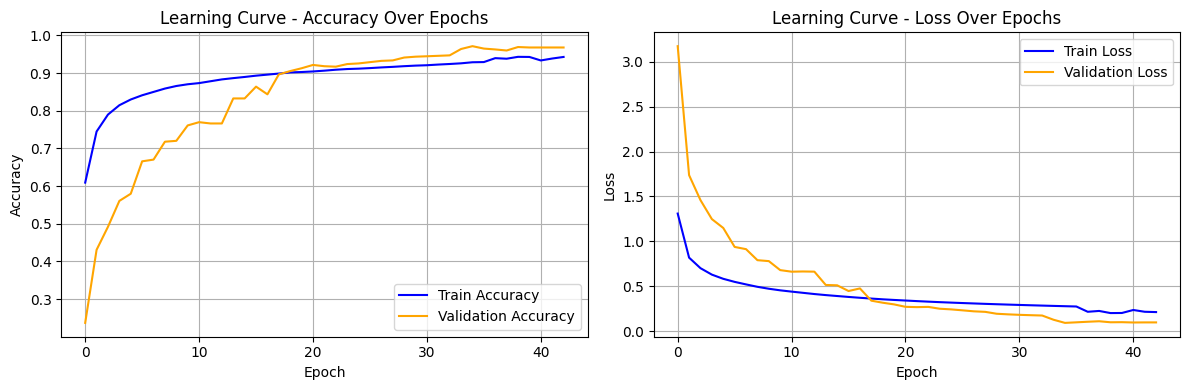

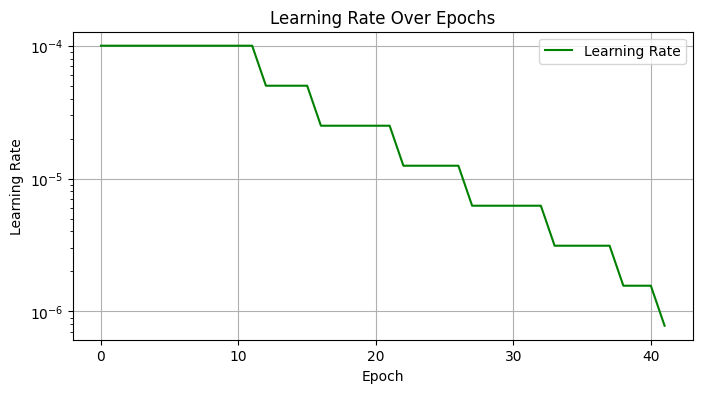


=== Training & Validation Performance Summary ===
Best Training Accuracy: 94.29% (Epoch 39)
Best Validation Accuracy: 97.12% (Epoch 35)
Best Training Loss: 0.2012 (Epoch 39)
Best Validation Loss: 0.0920 (Epoch 35)

Final Training Accuracy: 94.26%
Final Validation Accuracy: 96.77%
Final Training Loss: 0.2123
Final Validation Loss: 0.0974


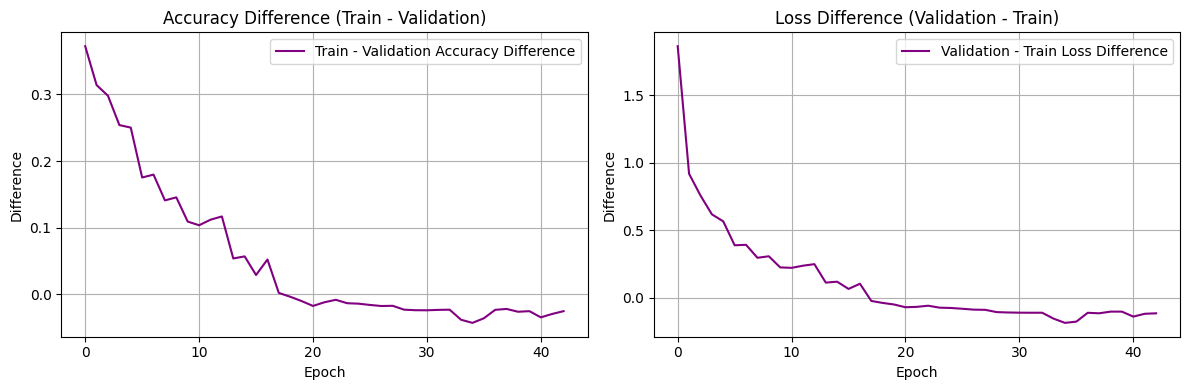


=== Final Observations ===
The model achieved excellent performance with Validation Accuracy >= 95%.
 No significant Overfitting: Train and Validation Accuracy are close.


In [14]:
plt.figure(figsize=(12, 4))
history_dict["val_accuracy"].append(history_dict["val_accuracy"][-1]) 
history_dict["val_loss"].append(history_dict["val_loss"][-1])  

plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Train Accuracy", color="blue")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy", color="orange")
plt.title("Learning Curve - Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Train Loss", color="blue")
plt.plot(history_dict["val_loss"], label="Validation Loss", color="orange")
plt.title("Learning Curve - Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("learning_curves.png")
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(history_dict["lr"], label="Learning Rate", color="green")
plt.title("Learning Rate Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale("log")   
plt.grid(True)
plt.legend()
plt.savefig("learning_rate_curve.png")
plt.show()

best_train_acc = max(history_dict["accuracy"])
best_val_acc = max(history_dict["val_accuracy"])
best_train_loss = min(history_dict["loss"])
best_val_loss = min(history_dict["val_loss"])

best_train_acc_epoch = np.argmax(history_dict["accuracy"]) + 1
best_val_acc_epoch = np.argmax(history_dict["val_accuracy"]) + 1
best_train_loss_epoch = np.argmin(history_dict["loss"]) + 1
best_val_loss_epoch = np.argmin(history_dict["val_loss"]) + 1

print("\n=== Training & Validation Performance Summary ===")
print(f"Best Training Accuracy: {best_train_acc * 100:.2f}% (Epoch {best_train_acc_epoch})")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}% (Epoch {best_val_acc_epoch})")
print(f"Best Training Loss: {best_train_loss:.4f} (Epoch {best_train_loss_epoch})")
print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_val_loss_epoch})")

final_train_acc = history_dict["accuracy"][-1]
final_val_acc = history_dict["val_accuracy"][-1]
final_train_loss = history_dict["loss"][-1]
final_val_loss = history_dict["val_loss"][-1]

print(f"\nFinal Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

acc_diff = np.array(history_dict["accuracy"]) - np.array(history_dict["val_accuracy"])
loss_diff = np.array(history_dict["val_loss"]) - np.array(history_dict["loss"])

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc_diff, label="Train - Validation Accuracy Difference", color="purple")
plt.title("Accuracy Difference (Train - Validation)")
plt.xlabel("Epoch")
plt.ylabel("Difference")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_diff, label="Validation - Train Loss Difference", color="purple")
plt.title("Loss Difference (Validation - Train)")
plt.xlabel("Epoch")
plt.ylabel("Difference")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("overfitting_analysis.png")
plt.show()


print("\n=== Final Observations ===")
if final_val_acc >= 0.95:
    print("The model achieved excellent performance with Validation Accuracy >= 95%.")
else:
    print(" Validation Accuracy is below 95%. Consider further tuning.")
if np.abs(final_train_acc - final_val_acc) > 0.05:
    print(" Potential Overfitting: Significant gap between Train and Validation Accuracy.")
else:
    print(" No significant Overfitting: Train and Validation Accuracy are close.")

In [16]:
model = load_model("best_model.h5")
 
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


report_dict = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("Classification Report:\n")
print(report_df)
report_df.to_csv("classification_report.csv")


27/27 [==============================] - 9s 320ms/step - loss: 0.0728 - accuracy: 0.9801
Test Accuracy: 98.01%
Test Loss: 0.0728
27/27 [==============================] - 9s 321ms/step
Classification Report:

              precision    recall  f1-score     support
Basophils      1.000000  1.000000  1.000000   41.000000
Blast          1.000000  0.973451  0.986547  339.000000
Eosinophils    0.921875  0.951613  0.936508   62.000000
Lymphocytes    0.941558  1.000000  0.969900  145.000000
Monocytes      0.968750  1.000000  0.984127   62.000000
Neutrophils    0.983871  0.924242  0.953125   66.000000
rbc            1.000000  1.000000  1.000000  140.000000
accuracy       0.980117  0.980117  0.980117    0.980117
macro avg      0.973722  0.978472  0.975744  855.000000
weighted avg   0.980913  0.980117  0.980188  855.000000


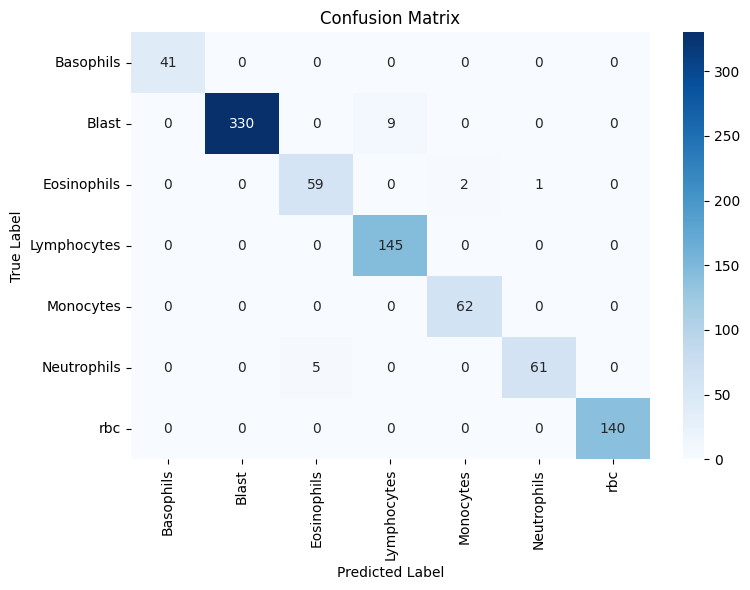

In [17]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


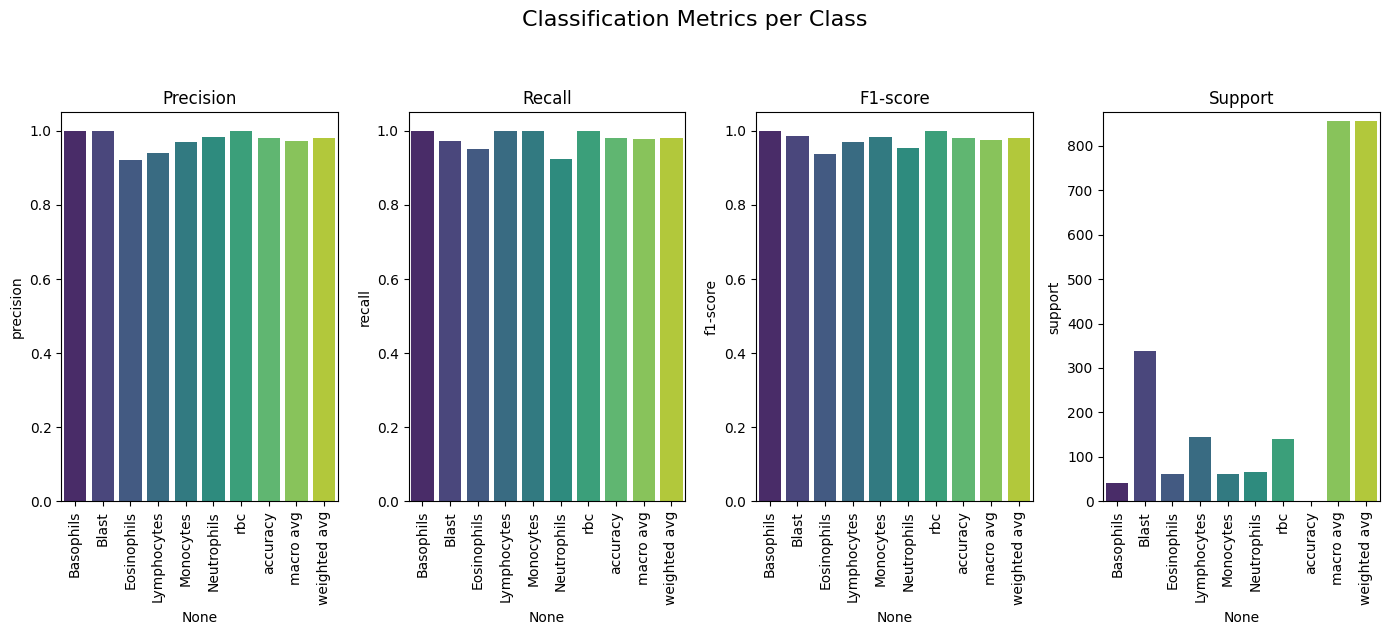

In [18]:
metrics = ["precision", "recall", "f1-score", "support"]
plt.figure(figsize=(14, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i + 1)
    sns.barplot(x=report_df.index, y=report_df[metric], palette="viridis")
    plt.xticks(rotation=90)
    plt.title(metric.capitalize())
    if metric != "support":
        plt.ylim(0, 1.05)
    else:
        plt.ylim(0, report_df["support"].max() + 20)
    plt.tight_layout()

plt.suptitle("Classification Metrics per Class", y=1.05, fontsize=16)
plt.tight_layout()
plt.savefig("classification_metrics_bars.png")
plt.show()